In [1]:
import os
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import wandb
from pathlib import Path
import orbax.checkpoint
from flax.training import train_state, orbax_utils
from sklearn.metrics import roc_auc_score, roc_curve, auc
import models
import data_utils
from tqdm import tqdm

api = wandb.Api()
# Project is specified by <entity/project-name>
runs = api.runs("mingfong/fullsim")

In [2]:
# TODO find the epochs with best val AUC to load weights from
runid_to_best_epoch = {}      # {runid: best epoch}
for run in runs:
  if run.config["seed"] != 1:
    continue
  print(run.id, run.name)
  hist = run.history()
  
  best_val_auc = 0
  best_epoch = 0
  for h in run.scan_history(keys=["epoch/epoch", "epoch/val_auc"], page_size=1000000):
    if h["epoch/val_auc"] > best_val_auc:
      best_val_auc = h["epoch/val_auc"]
      best_epoch = h["epoch/epoch"]
  runid_to_best_epoch[run.id] = best_epoch
  print(f"best_epoch = {best_epoch}, best_val_auc = {best_val_auc}")

4rqwunj6 fullsim_transfered1 16M rows
best_epoch = 83, best_val_auc = 0.9495919002082218
gb736s9n fullsim_transfered1 8M rows
best_epoch = 63, best_val_auc = 0.947032040368811
a2ypm3lr fullsim_transfered1 4M rows
best_epoch = 56, best_val_auc = 0.9443434581562347
co3u843s fullsim_transfered1 2M rows
best_epoch = 61, best_val_auc = 0.9404757406456324
ujrwfssb fullsim_only1
best_epoch = 177, best_val_auc = 0.9491437161051897


## Inference Pipeline on TEST dataset

In [3]:
def init_train_state(rng_key, model, optimizer, batch):
  """Initialize training state."""
  params = model.init(rng_key, batch)
  return train_state.TrainState.create(
      apply_fn=model.apply,
      params=params,
      tx=optimizer)

@jax.jit
def eval_step(
  state: train_state.TrainState,
  batch: jnp.ndarray,
  ):
  """Perform a single evaluation step."""
  x, y = batch
  logits = state.apply_fn(state.params, x).squeeze()
  loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=y))
  return loss, logits

In [4]:
def inference_loop(checkpoint_dir: Path, test_dataloader: data_utils.JaxDataLoader, seed: int=1):
  """
  Gets inference predictions for a given checkpoint directory.
  checkpoint_dir example: /pscratch/sd/m/mingfong/transfer-learning/checkpoints/532gak2v/
  Output: y_true, y_pred
  """
  rng = np.random.RandomState(seed)
  rng_key = jax.random.PRNGKey(rng.randint(2**32))
  DNN_LAYERS = [400, 400, 400, 400, 400, 1]
  LEARNING_RATE = 0.0001

  dummy_input = next(iter(test_dataloader))[0]
  print(f"Input shape: {dummy_input.shape}")

  model = models.MLP(features=DNN_LAYERS)
  opt = optax.adam(LEARNING_RATE)
  state = init_train_state(rng_key, model, opt, dummy_input)

  # load checkpoint for params
  ckpt = {
    "step": 0,
    "state": state,
  }
  orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
  # save_args = orbax_utils.save_args_from_target(ckpt)

  # CHECKPOINT_DIR = Path("/pscratch/sd/m/mingfong/transfer-learning/checkpoints/532gak2v/")
  raw_restored = orbax_checkpointer.restore(checkpoint_dir, item=ckpt)
  state = raw_restored["state"]
  # start_step = raw_restored["step"] + 1
  
  test_datagen = iter(test_dataloader)
  test_batch_matrics = {
    "loss": [],
    "accuracy": [],
    "auc": [],
  }
  logits_list = []
  y_true_list = []

  for batch_step in tqdm(range(len(test_dataloader))):
    batch = next(test_datagen)
    loss, logits = eval_step(state, batch)
    test_batch_matrics["loss"].append(loss)
    test_batch_matrics["accuracy"].append(jnp.mean((logits > 0) == batch[1]))
    test_batch_matrics["auc"].append(roc_auc_score(batch[1], logits))
    logits_list.append(logits)
    y_true_list.append(batch[1])
    
  y_true = np.concatenate(y_true_list)
  y_pred = np.concatenate(logits_list)
  print(f"y_true: {y_true.shape}")
  print(f"y_pred: {y_pred.shape}")
  return y_true, y_pred

In [5]:
# testing data loading
BATCH_SIZE = 1024
MAX_ROWS = None # None for all

test_dir_preprocess = "/pscratch/sd/m/mingfong/transfer-learning/fullsim_test_processed/"
test_preprocess_file_names = os.listdir(test_dir_preprocess)
test_preprocess_filepaths = [test_dir_preprocess + name for name in test_preprocess_file_names]

DatasetClassToUse = data_utils.H5DatasetLoadAll

test_dataset = DatasetClassToUse(test_preprocess_filepaths[-1:], max_rows=MAX_ROWS, reverse_data=True)
test_dataloader = data_utils.JaxDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Num val samples: {len(test_dataset)}")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:25<?, ?it/s]

Num val samples: 2484117


In [23]:
CHECKPOINT_DOWNLOAD_DIR = Path("/pscratch/sd/m/mingfong/transfer-learning/checkpoints/")
output_dict = {} # {run_id: (y_true, y_pred)}

for run in runs:
  if run.config["seed"] != 1:
    continue
  print(f"{run.name}: {run.id} (seed: {run.config['seed']})")
  best_epoch = (runid_to_best_epoch[run.id] // 10) - 1     # we only save checkpoints every 10 epochs
  print("Downloading artifact ")
  artifact = api.artifact(f"mingfong/fullsim/{run.id}-checkpoint:v{best_epoch}")
  artifact_path = CHECKPOINT_DOWNLOAD_DIR / run.id
  artifact.download(artifact_path)
  print(f"Downloaded {run.id} to {artifact_path}")
  output_dict[run.id] = inference_loop(artifact_path, test_dataloader, seed=run.config["seed"])

fullsim_transfered1 16M rows: 4rqwunj6 (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded 4rqwunj6 to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/4rqwunj6
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:26<00:00, 90.73it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered1 8M rows: gb736s9n (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded gb736s9n to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/gb736s9n
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:27<00:00, 88.48it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered1 4M rows: a2ypm3lr (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded a2ypm3lr to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/a2ypm3lr
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:26<00:00, 91.56it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_transfered1 2M rows: co3u843s (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded co3u843s to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/co3u843s
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:27<00:00, 88.88it/s]


y_true: (2484117,)
y_pred: (2484117,)
fullsim_only1: ujrwfssb (seed: 1)


wandb:   1 of 1 files downloaded.  


Downloaded ujrwfssb to /pscratch/sd/m/mingfong/transfer-learning/checkpoints/ujrwfssb
Input shape: (1024, 1400)


100%|██████████| 2426/2426 [00:26<00:00, 90.26it/s]

y_true: (2484117,)
y_pred: (2484117,)


4rqwunj6
roc_auc = 0.9495745621430791
gb736s9n
roc_auc = 0.9469682774034334
a2ypm3lr
roc_auc = 0.94429247892411
co3u843s
roc_auc = 0.940211816590935
ujrwfssb
roc_auc = 0.949004607703953


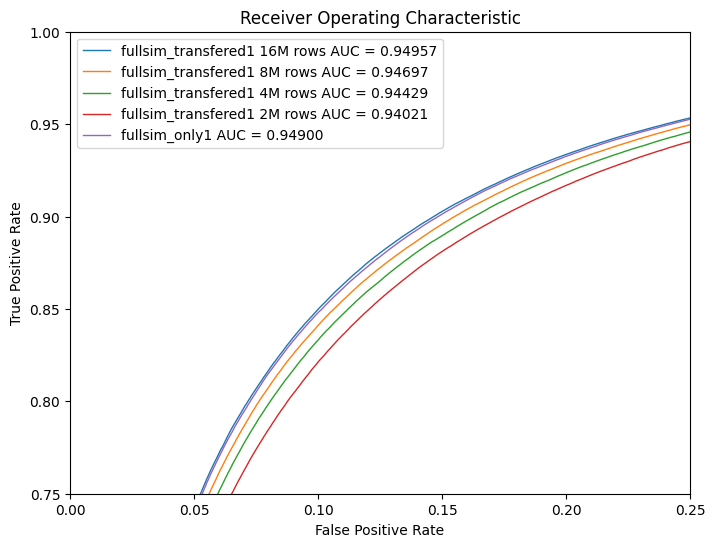

In [26]:
plt.figure(figsize=(8,6))
for run in runs:
  if run.id not in output_dict:
    continue
  print(run.id)
  y_true, y_pred = output_dict[run.id]
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  print(f"roc_auc = {roc_auc}")
  plt.plot(fpr, tpr, label = f'{run.name} AUC = %0.5f' % roc_auc, linewidth=1.0)
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 0.25])
plt.ylim([0.75, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

4rqwunj6


0.9495745621430791
gb736s9n
0.9469682774034334
a2ypm3lr
0.94429247892411
co3u843s
0.940211816590935
ujrwfssb
0.949004607703953


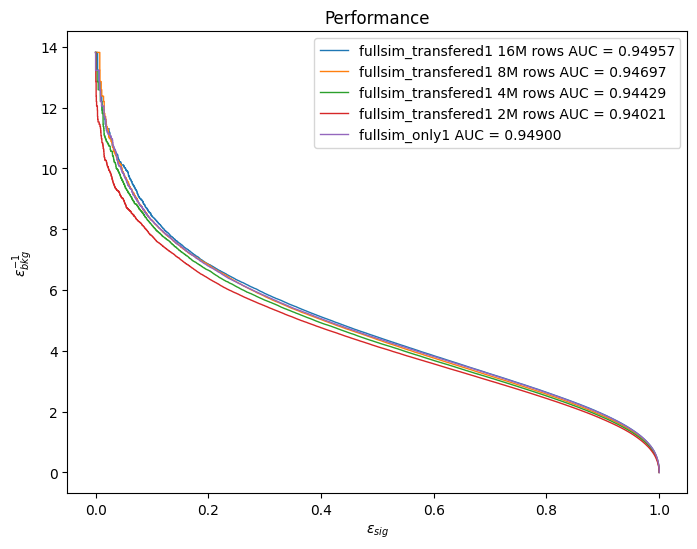

In [27]:
# log(1/fpr) on y
# tpr on x axis
EPS = 1e-6                  # TODO ask ben about div by zero

plt.figure(figsize=(8,6))
for run in runs:
  if run.id not in output_dict:
    continue
  print(run.id)
  y_true, y_pred = output_dict[run.id]
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  print(roc_auc)
  plt.plot(tpr, np.log(1 / (fpr + EPS)), label = f'{run.name} AUC = %0.5f' % roc_auc, linewidth=1.0)
plt.title("Performance")
plt.legend()
plt.ylabel(r"$\epsilon_{bkg}^{-1}$")
plt.xlabel(r"$\epsilon_{sig}$")
# plt.yscale("log")
plt.show()

4rqwunj6
0.9495745621430791
tpr = 0.5
fpr = 0.01162292081498019
gb736s9n
0.9469682774034334
tpr = 0.4999919429041963
fpr = 0.012659144391480118
a2ypm3lr
0.94429247892411
tpr = 0.4999983885808393
fpr = 0.013933506305436553
co3u843s
0.940211816590935
tpr = 0.4999991942904196
fpr = 0.015964922866509784
ujrwfssb
0.949004607703953
tpr = 0.4999983885808393
fpr = 0.012173213459643195


Text(0, 0.5, 'log(1/fpr)')

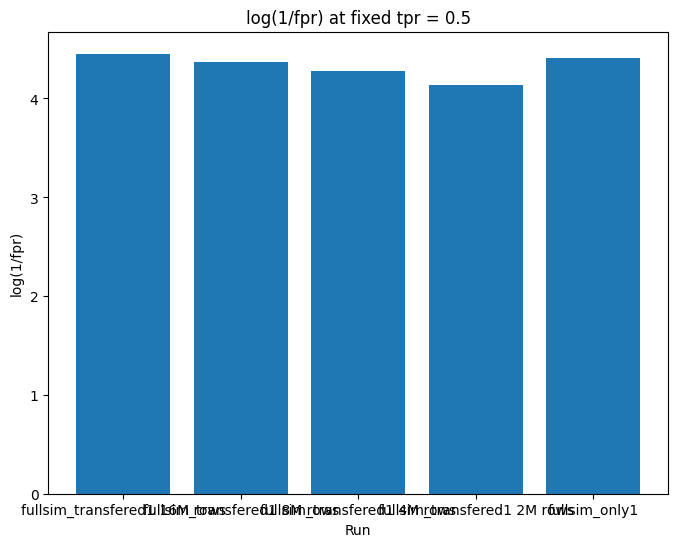

In [28]:
# fix tpr at {50%} and get get log(1/fpr)
# table or plot
# error bars std over 5 runs

fixed_tpr = 0.5
plt.figure(figsize=(8,6))
xaxis_runes = []
heights = []
for run in runs:
  if run.id not in output_dict:
    continue
  print(run.id)
  xaxis_runes.append(run.name)
  y_true, y_pred = output_dict[run.id]
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  print(roc_auc)
  idx = np.argmin((tpr - fixed_tpr)**2)
  print(f"tpr = {tpr[idx]}")
  print(f"fpr = {fpr[idx]}")
  heights.append(np.log(1 / (fpr[idx] + EPS)))
# bar plot
plt.bar(xaxis_runes, heights)
plt.title(f"log(1/fpr) at fixed tpr = {fixed_tpr}")
plt.xlabel("Run")
plt.ylabel("log(1/fpr)")